Some imports

In [2]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from bpemb import BPEmb

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

Load the data

In [3]:
df = pd.read_csv('data/preprocessed.csv')
df.head()

,Unnamed: 0,preprocessed_text,sentiment
0,0,теперь я знаю чего хочу на нг:dd ^^,1
1,1,скоро матч робин-локо болею сегодня за рубин н...,1
2,2,перестаньте а (,0
3,3,матвейка милааааш^^ соскучилась по нему),1
4,4,блиин:с я и на концеерт хочу теперь:((((( а т...,0


Load BPE model

In [4]:
bpe = BPEmb(lang='ru', vs=30000)
print(bpe.encode('Привет, ну как ты там поживаешь? :) Слышал, что у тебя были недавно серьёзные проблемы'))

BPEmb fallback: ru from vocab size 30000 to 200000
['▁привет', ',', '▁ну', '▁как', '▁ты', '▁там', '▁по', 'жива', 'ешь', '?', '▁:', ')', '▁слышал', ',', '▁что', '▁у', '▁тебя', '▁были', '▁недавно', '▁серьёзные', '▁проблемы']


Translate tokenized text to indices in embedding dictionary

In [5]:
def text_data_to_tokens(texts):
    res = []
    for txt in texts:
        tokenized_txt = bpe.encode(txt)
        replaced_by_num = [bpe.emb.vocab[word].index for word in tokenized_txt if word in bpe.emb.vocab]
        res.append(replaced_by_num)
    return res

In [6]:
X = text_data_to_tokens(list(df['preprocessed_text']))
print(X[:2])

[[4644, 169, 27930, 2099, 27663, 35, 37544, 199947, 34878, 199898], [2347, 4558, 14794, 199936, 69101, 8165, 199928, 4535, 71, 26328, 78002, 806, 28188, 16366, 268, 157717, 1062, 15, 59133, 7355, 5067, 57269, 35, 185511, 199937]]


Train/test split

In [8]:
data_train, data_test, label_train, label_test = train_test_split(
    X,
    df['sentiment'],
    test_size=0.3,
    shuffle=True,
    random_state=42
)

Longest sentence length

In [9]:
max([len(x) for x in X])

689

Embedding layer params

In [10]:
bpe.emb.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 200000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [11]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Training

In [12]:
maxlen = 700
batch_size = 256
epochs = 10

X_train = sequence.pad_sequences(data_train, maxlen=maxlen)
X_test = sequence.pad_sequences(data_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(label_train)
y_test = np.array(label_test)

model = Sequential()
model.add(bpe.emb.get_keras_embedding())
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [ModelCheckpoint(filepath='trained_models/bpe_bilstm.h5', 
                             monitor='val_loss', 
                             save_best_only=True)
            ]
model.compile('adadelta', 'binary_crossentropy', metrics=[precision, recall, f1])
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.15, 
    callbacks=callbacks
)

X_train shape: (159835, 700)
X_test shape: (68502, 700)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 135859 samples, validate on 23976 samples
Epoch 1/10
135859/135859 [==============================] - 918s 7ms/step - loss: 0.1780 - precision: 0.9114 - recall: 0.9545 - f1: 0.9302 - val_loss: 0.0844 - val_precision: 0.9565 - val_recall: 0.9864 - val_f1: 0.9711
Epoch 2/10
135859/135859 [==============================] - 903s 7ms/step - loss: 0.0657 - precision: 0.9707 - recall: 0.9843 - f1: 0.9773 - val_loss: 0.0493 - val_precision: 0.9725 - val_recall: 0.9916 - val_f1: 0.9819
Epoch 3/10
135859/135859 [==============================] - 900s 7ms/step - loss: 0.0405 - precision: 0.9835 - recall: 0.9887 - f1: 0.9860 - val_loss: 0.0355 - val_precision: 0.9774 - val_recall: 0.9958 - val_f1: 0.9865
Epoch 4/10


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         20000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 20,301,501
Trainable params: 301,501
Non-trainable params: 20,000,000
_________________________________________________________________


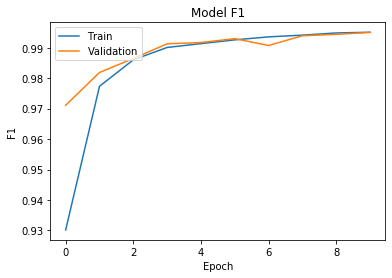

In [14]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

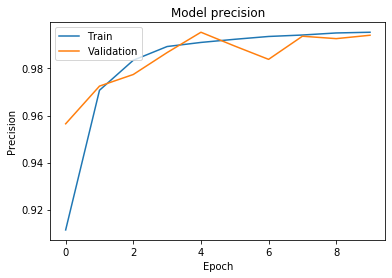

In [15]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

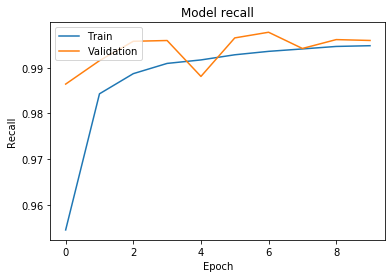

In [16]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

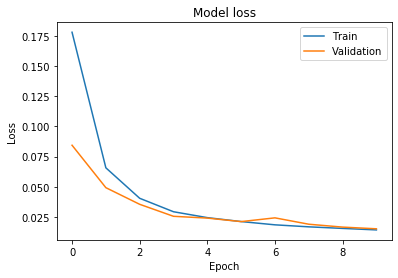

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [18]:
print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33742
           1       0.99      0.99      0.99     34760

    accuracy                           0.99     68502
   macro avg       0.99      0.99      0.99     68502
weighted avg       0.99      0.99      0.99     68502

